## Variational inference in Dirichlet Process Normal Mixture

In [3]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt
import DP_lrvb as lrvb

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [36]:
np.random.seed(52432)
# np.random.seed(54325)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 2 # true number of clusters

info_x = 0.1 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 1.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_info = 0.1 * np.eye(x_dim)

# variational truncation 
k_approx = 100



observed mixture proportions: 
 [ 0.514  0.486]
true mixture proportions: 
 [ 0.5  0.5]


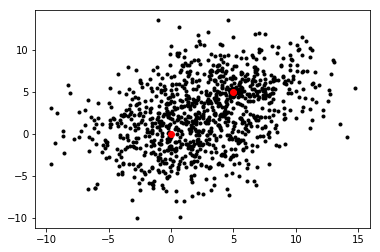

In [37]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

# Set up VB model

In [23]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [24]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [25]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

# Initialize

In [26]:
## initialize VB params

true_init = False

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    # z_size = vb_params['local']['e_z'].free_size()
    # vb_params['local']['e_z'].set_free(np.random.random(z_size))
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

# Run CAVI 

max iteration reached
elbo:  -332.06560276


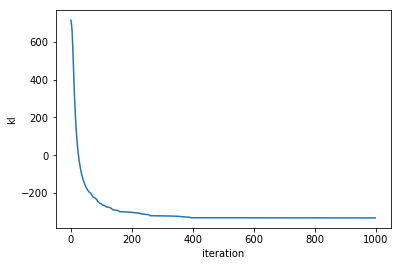

In [27]:
dp_opt.run_cavi(model, init_free_params, max_iter = 1000, tol = 1e-5, disp = False)
cavi_results = deepcopy(model)
print('elbo: ', cavi_results.get_kl())


### examine results of CAVI

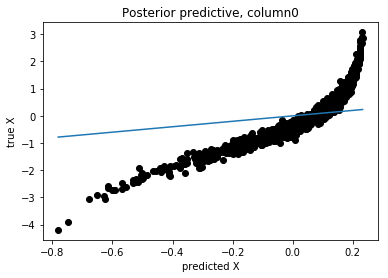

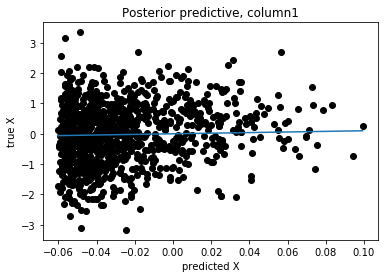

In [28]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [29]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights 

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

print(post_pi[heavy_clusters])

true_proportions [ 1.]
estimated proportions:  [  9.98003992e-04   2.02924719e-01   7.95081516e-01   4.97880444e-04
   2.48940222e-04   1.24470111e-04   6.22350555e-05   3.11175278e-05
   1.55587639e-05   7.77938194e-06   3.88969097e-06   1.94484548e-06
   9.72422742e-07   4.86211371e-07   2.43105686e-07   1.21552843e-07
   6.07764214e-08   3.03882107e-08   1.51941053e-08   7.59705267e-09
   3.79852634e-09   1.89926317e-09   9.49631584e-10   4.74815792e-10
   2.37407896e-10   1.18703948e-10   5.93519740e-11   2.96759870e-11
   1.48379935e-11   7.41899675e-12   3.70949838e-12   1.85474919e-12
   9.27374594e-13   4.63687297e-13   2.31843649e-13   1.15921824e-13
   5.79609121e-14   2.89804561e-14   1.44902280e-14   7.24511402e-15
   3.62255701e-15   1.81127850e-15   9.05639252e-16   4.52819626e-16
   2.26409813e-16   1.13204906e-16   5.66024532e-17   2.83012266e-17
   1.41506133e-17   7.07530666e-18   3.53765333e-18   1.76882666e-18
   8.84413332e-19   4.42206666e-19   2.21103333e-19   1.

In [30]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
post_mean = cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :]
print(post_mean)

true means: 
[[0 0]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[-0.83883019  0.10836493]
 [ 0.2393387  -0.0611711 ]]


here, black are data points. red are the true means. blue are the posterior means


"post_info = cavi_results.vb_params['global']['info'].get()[heavy_clusters]\ntheta = np.linspace(0, 2 * np.pi, 100)\nunit_circ = np.array([np.cos(theta), np.sin(theta)])\n\nfor k in range(np.shape(post_mean)[0]):\n    plt.plot()"

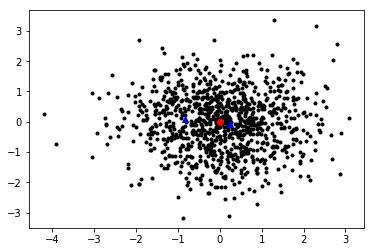

In [31]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    

print('here, black are data points. red are the true means. blue are the posterior means')


"""post_info = cavi_results.vb_params['global']['info'].get()[heavy_clusters]
theta = np.linspace(0, 2 * np.pi, 100)
unit_circ = np.array([np.cos(theta), np.sin(theta)])

for k in range(np.shape(post_mean)[0]):
    plt.plot()"""

# Newton Optimization

In [14]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [15]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-6, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hessp=kl_obj.fun_free_hvp,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done :o')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

Optimization terminated successfully.
         Current function value: -186.202558
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 0
done :o


In [16]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

In [24]:
# checking the optima

print('minimizing function value', newton_results.get_kl())

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian eigenvalues all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

minimizing function value -1146.99409105
L_inf norm of gradient:  1.24835419622e-09
time to compute Hessian (sec):  8.294189691543579
Hessian eigenvalues all positive:  True
distance (l2) to minimizer of quadratic approx. :  1.30916027199e-08


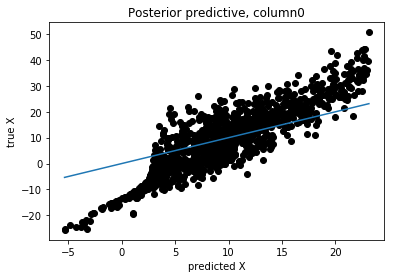

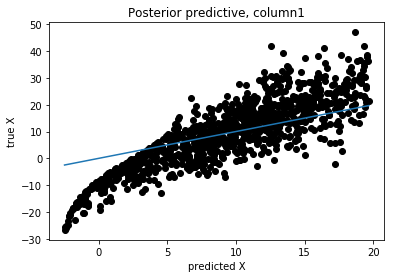

In [25]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [26]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference (normalized) between means: ', \
      np.mean(np.abs(cavi_results.vb_params['global']['mu'].get() \
                     - newton_results.vb_params['global']['mu'].get())))

[[  2.92019425  -2.97300045]
 [ 10.20556893  11.37493211]
 [ 23.34675977  19.84349585]
 [ -7.6282461    5.99694731]
 [ 10.00355164   9.52330963]
 [ 10.00408795   9.52492508]
 [ 10.00434089   9.52568569]
 [ 10.00447662   9.52609351]
 [ 10.00455382   9.52632537]
 [ 10.00434488   9.52569769]]
[[  2.92218962  -2.90214867]
 [ 10.24209191  11.42310312]
 [ 23.3874361   19.8534184 ]
 [ -7.66358537   6.0318989 ]
 [ 10.00355796   9.52329064]
 [ 10.00409114   9.524915  ]
 [ 10.00434267   9.52567996]
 [ 10.00447765   9.52609015]
 [ 10.00455444   9.52632337]
 [ 10.00434663   9.52569203]]
l1 difference (normalized) between means:  0.0139245699047


In [27]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_free() - newton_results.vb_params.get_free())))

l1 difference (normalized) between all params:  0.0243558421181


# Parametric sensitivity analysis

In particular, we are interested in how posterior quantities depend on our choice of DP parameter $\alpha$. 

As a first step, lets manually perturb $\alpha$ and re-optimize. We will then compare these perturbed results with the sensitivity predicted by LRVB. 

In [28]:
epsilon = 0.1 # how much we will perturb alpha

model_perturbed = deepcopy(newton_results)
model_perturbed.alpha = alpha + epsilon # perturb dp parameter

# define new objective
kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

# find new optima
newton_tr_opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6))

model_perturbed.vb_params['global'].set_free(newton_tr_opt_perturbed.x) 
model_perturbed.set_optimal_z()

Optimization terminated successfully.
         Current function value: -1146.133990
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
done :o


In [29]:
# checking the optima

# check that the gradient is close to 0
kl_grad = kl_obj_perturbed.fun_free_grad(newton_tr_opt_perturbed.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj_perturbed.fun_free_hessian(newton_tr_opt_perturbed.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian evals all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

L_inf norm of gradient:  6.22884392295e-09
time to compute Hessian (sec):  8.271716117858887
Hessian evals all positive:  True
distance (l2) to minimizer of quadratic approx. :  1.23329498149e-07


Now, lets do LRVB and get predicted sensitivities for various posterior quantities

### V_stick sensitivity

As a first pass, we look at the sensitivity of the posterior stick lengths to our choice of DP parameter $\alpha$

In [30]:
def get_v_sticks(model, global_free_params): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    return model.vb_params['global']['v_sticks'].e()[:,0]

# compute LRVB sensitivity
alpha_sensitivity = lrvb.DPAlphaSensitivity(model, newton_tr_opt.x)
lrvb_sens_v_sticks = alpha_sensitivity.get_param_sensitivity(lambda x : get_v_sticks(model, x))

print('LRVB predicted_sensitivity: \n', lrvb_sens_v_sticks)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
old_mean = newton_results.vb_params['global']['v_sticks'].e()[:,0]

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

evaluating hessian ...
ok
LRVB predicted_sensitivity: 
 [-0.00081895 -0.00196564 -0.00609625 -0.0205415  -0.11551671 -0.1143885
 -0.1145883  -0.11493551 -0.11525006]
true sensitivity: 
 [-0.00082048 -0.00197796 -0.00612227 -0.02060138 -0.11228763 -0.11110991
 -0.11127146 -0.11159321 -0.11189005]


### Cluster mean sensitivity

We can also check the sensitivity of posterior means to $\alpha$. 

In [31]:
def get_cluster_means(model, global_free_params): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()
    
    return model.vb_params['global']['mu'].get_vector()

# compute LRVB sensitivity
lrvb_sens_means = alpha_sensitivity.get_param_sensitivity(lambda x : get_cluster_means(model, x))

print('LRVB predicted_sensitivity: \n', lrvb_sens_means)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['mu'].get_vector()
old_mean = newton_results.vb_params['global']['mu'].get_vector()

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

LRVB predicted_sensitivity: 
 [ 0.01441689 -0.01540194  0.00373209  0.00059403 -0.00085641  0.00143144
  0.04290452 -0.01894364 -0.00045116 -0.00132199 -0.0003786  -0.00112403
 -0.00029012 -0.00086607 -0.0002145  -0.0006424  -0.00015493 -0.00046501
 -0.00067912 -0.00204864]
true sensitivity: 
 [ 0.01445155 -0.01544039  0.00375053  0.00062419 -0.00085809  0.00143382
  0.0430225  -0.01898449 -0.00044339 -0.00129496 -0.00037596 -0.00111366
 -0.00029091 -0.00086687 -0.00021727 -0.00064967 -0.00015861 -0.00047537
 -0.00072897 -0.00219623]


### Co-clustering sensitivity

Since this is a clustering problem, we can check other moments too: like co-clustering. In particular, for two data points indexed by $n_1$ and $n_2$, we can check the sensitivty of $E[z_{n_1} \cdot z_{n_2}]$, the indicator that $x_{n_1}$ and $x_{n_2}$ belong to the same cluster.

In [32]:
def get_co_clustering(model, global_free_params, n1, n2): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    e_z1 = model.vb_params['local']['e_z'].get()[n1, :]
    e_z2 = model.vb_params['local']['e_z'].get()[n2, :]
    
    return np.dot(e_z1, e_z2)

cluster of first data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 10.20556893  11.37493211]
cluster mean of first data point:  [ 10.20556893  11.37493211]

here, black are data points. red are the true means. 
blue are the posterior means. yellow are the chosen data points. 


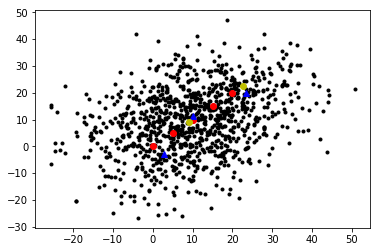

In [33]:
# choose two data points
n1 = 0
n2 = 1

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. yellow are the chosen data points. ')

In [34]:
lrvb_sens_co_cluster = alpha_sensitivity.get_param_sensitivity(\
                                        lambda x: get_co_clustering(model, x, n1, n2))

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)
co_clustering = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
    newton_results.vb_params['local']['e_z'].get()[n2, :])
    
co_clustering_pert = np.dot(model_perturbed.vb_params['local']['e_z'].get()[n1, :], \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :])

print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)


predicted_sensitivity: 
 -0.0004605964149
true_sensitivty: 
 -0.000472675343959


cluster of first data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 10.20556893  11.37493211]
cluster mean of first data point:  [ 2.92019425 -2.97300045]

here, black are data points. red are the true means. 
blue are the posterior means. yellow are the chosen data points. 


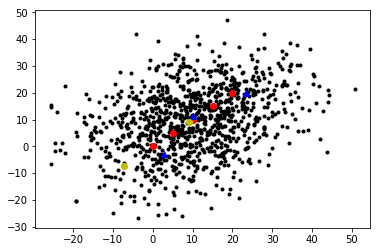

In [35]:
# choose two data points
n1 = 0
n2 = 2

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. yellow are the chosen data points. ')


In [36]:
lrvb_sens_co_cluster = alpha_sensitivity.get_param_sensitivity(\
                                        lambda x: get_co_clustering(model, x, n1, n2))

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)

co_clustering = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
    newton_results.vb_params['local']['e_z'].get()[n2, :])
    
co_clustering_pert = np.dot(model_perturbed.vb_params['local']['e_z'].get()[n1, :], \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :])

print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)

predicted_sensitivity: 
 -0.000874695455609
true_sensitivty: 
 -0.000878062319803


so we see that the co-clustering of two data points which are close is more sensitive to alpha than two data points that are far away

## Let us check the linearity of the perturbation in alpha

In [37]:
epsilons = np.arange(-2.0, 2.2, 0.2) # the range for which we will perturb alpha

results = np.zeros((len(epsilons), model.vb_params.free_size()))

for i in range(len(epsilons)): 
    print(epsilons[i])
    model_perturbed = deepcopy(newton_results)
    model_perturbed.alpha  = alpha + epsilons[i] # perturb dp parameter

    # define new objective
    kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

    # find new optima
    opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6), disp = False)
    
    # set to optima
    model_perturbed.vb_params['global'].set_free(opt_perturbed.x) 
    model_perturbed.set_optimal_z()
    
    results[i, :] = model_perturbed.vb_params.get_free()    

-2.0
done :o
-1.8


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)


done :o
-1.6
done :o
-1.4
done :o
-1.2
done :o
-1.0
done :o
-0.8
done :o
-0.6
done :o
-0.4
done :o
-0.2
done :o
-4.4408920985e-16
done :o
0.2
done :o
0.4
done :o
0.6
done :o
0.8
done :o
1.0
done :o
1.2
done :o
1.4
done :o
1.6
done :o
1.8
done :o
2.0
done :o


In [38]:
k_stick = 1

perturbed_v_sticks = np.zeros(len(epsilons))
perturbed_co_clusters = np.zeros(len(epsilons))

for i in range(len(epsilons)): 
    model.vb_params.set_free(results[i,:])
    perturbed_v_sticks[i] = model.vb_params['global']['v_sticks'].e()[k_stick, 0]
    
    perturbed_co_clusters[i] = np.dot(model.vb_params['local']['e_z'].get()[n1, :], \
                                model.vb_params['local']['e_z'].get()[n2, :])


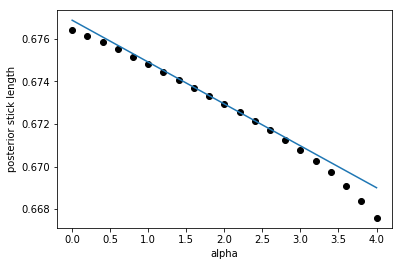

In [39]:
plt.plot(alpha + epsilons, perturbed_v_sticks, 'ko')
# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_mean = newton_results.vb_params['global']['v_sticks'].e()[k_stick, 0]
plt.plot(x_axis, lrvb_sens_v_sticks[k_stick] * (x_axis - alpha) + old_mean)
plt.xlabel('alpha')
plt.ylabel('posterior stick length')

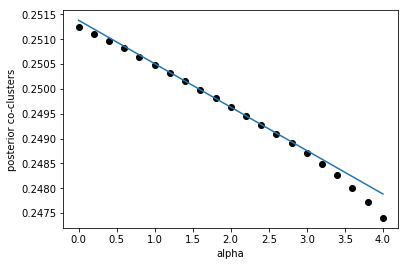

In [40]:
plt.plot(alpha + epsilons, perturbed_co_clusters, 'ko')

# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_co_cluster = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
                                newton_results.vb_params['local']['e_z'].get()[n2, :])
plt.plot(x_axis, lrvb_sens_co_cluster * (x_axis - alpha) + old_co_cluster)
plt.xlabel('alpha')
plt.ylabel('posterior co-clusters')